In [11]:
import os
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import Graph, StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import  AIMessage, HumanMessage, ToolMessage

from langchain_community.tools.tavily_search import TavilySearchResults

load_dotenv(dotenv_path="../.env")

# Create the llm structure
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.5)
#model = ChatOpenAI(model="gpt-4")
tool = TavilySearchResults(max_results=2)
tools = [tool]
#tool.invoke("What's a 'node' in LangGraph?")

llm_with_tools = model.bind_tools(tools)

In [2]:
class CustomState(TypedDict):
    messages: Annotated[list, add_messages]

In [13]:
def node1(state: CustomState):
    return {"messages": [AIMessage(content="Hello! What can I do for you today?")]}

def node2(state: CustomState):    
    return {"messages": [HumanMessage(content="Nothing, thank you and goodbye!")]}

def chatbot(state: CustomState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

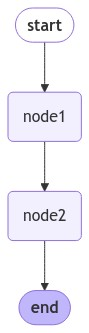

In [14]:
graph = StateGraph(CustomState)
graph.add_node("node1", node1)
graph.add_node("node2", node2)
graph.add_edge(START, "node1")
graph.add_edge("node1", "node2")
graph.add_edge("node2", END)
app = graph.compile()
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [5]:
input: CustomState = {
    "messages":[HumanMessage(content="Hello, I am a user!")]
}

for output in app.stream(input):
    for key, value in output.items():
        # This is the output BEFORE the reducer function "add_messages" is applied
        print(f"Output from node '{key}':")
        print("---")
        print(value['messages'][-1].content)
    print("\n---\n")    
app.invoke(input)

Output from node 'node1':
---
Hello! What can I do for you today?

---

Output from node 'node2':
---
Nothing, thank you and goodbye!

---



{'messages': [HumanMessage(content='Hello, I am a user!', id='c7b8d727-1504-494a-bc2a-48079770dc4c'),
  AIMessage(content='Hello! What can I do for you today?', id='8d2e23bd-23be-4647-8db7-107778130d96'),
  HumanMessage(content='Nothing, thank you and goodbye!', id='9bfa8b6c-673c-4ba4-bd9c-b1b23a53a528')]}

In [53]:
graph_builder = StateGraph(CustomState)
graph_builder.add_node("chatbot", chatbot) 

In [54]:
import json
class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}
    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No messages found in inputs")

        outputs = []
        for tool_call in message.tool_calls:

            print(tool_call)
            tool = self.tools_by_name[tool_call["name"]]

            tool_result = tool.invoke(tool_call["args"])
            outputs.append(ToolMessage(content=json.dumps(tool_result), name=tool_call["name"], tool_call_id=tool_call["id"]))

        return {"messages": outputs}

tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [55]:
from typing import Literal

def route_tools(
    state: CustomState,
    ) -> Literal["tools", "__end__"]:
    """ Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end. """

    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


In [56]:
graph_builder.add_conditional_edges(
    "chatbot", 
    route_tools, 
    {"tools": "tools", "__end__": "__end__"}
    )

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

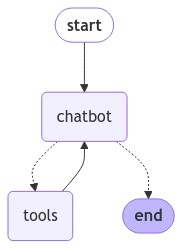

In [57]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [62]:
input = {"messages": [HumanMessage(content="Hello, what can you tell me about the LangGraph framework?")]}
#for event in graph.stream(input):
##    for value in event.values():
##        if isinstance(value["messages"][-1], BaseMessage):
##            print("Assistant:", value["messages"][-1].content)
#    for key, value in event.items():
#        print(f"Output from node '{key}':")
#        print("---")
#        print(value)
#    print("\n---\n")            
response = graph.invoke(input)
print(response["messages"][-1].content)

{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph framework'}, 'id': 'call_bisU8iNs1NPpwsJZnBWB5fNz', 'type': 'tool_call'}
The LangGraph framework is a low-level framework that is part of the LangChain ecosystem. It is known for offering extensive customization options, allowing developers to build complex Large Language Model (LLM) applications with precision. LangGraph is seamlessly integrated into the LangChain ecosystem, making it easy to leverage its capabilities. You can find more information about LangGraph on the [LangChain website](https://www.langchain.com/langgraph) and on this [article](https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787).
